## Data Loading and Visualization

In [1]:
import pickle
import matplotlib.pyplot as plt 
from PIL import Image

#Load Traffic Sign Data
with open('data/data1.pickle', 'rb') as f:
    data = pickle.load(f)

print("x train shape:", data["x_train"].shape)
print("y train shape:", data["y_train"].shape)
print("x test shape:", data["x_test"].shape)
print("y test shape:", data["y_test"].shape)
print("x validation shape:", data["x_validation"].shape)
print("y validation shape:", data["y_validation"].shape)


x train shape: (86989, 3, 32, 32)
y train shape: (86989,)
x test shape: (12630, 3, 32, 32)
y test shape: (12630,)
x validation shape: (4410, 3, 32, 32)
y validation shape: (4410,)


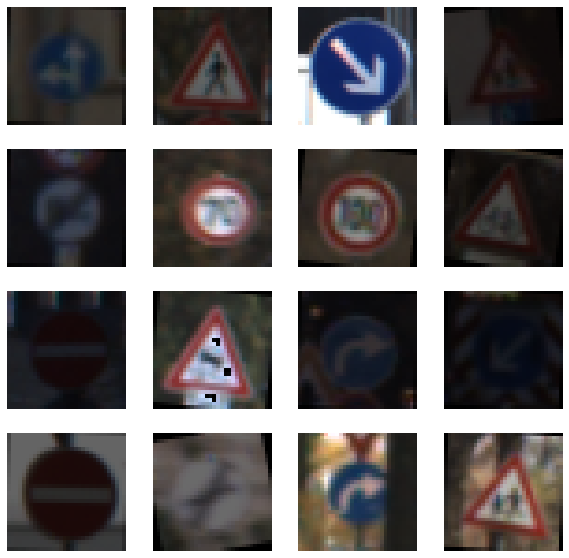

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
num_classes = 43
x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_validation"]
y_train = data["y_train"]
y_val = data["y_validation"]
y_test = data["y_test"]

#Transpose images so that channel dim is last
x_train = x_train.transpose(0, 2, 3, 1)
x_val = x_val.transpose(0, 2, 3, 1)
x_test = x_test.transpose(0, 2, 3, 1)

##Dataset has already been normalized
plt.figure(figsize=(10,10)) 

for i in range(16):
    plt.subplot(4,4,i+1)   
    plt.imshow(x_train[i])
    plt.axis("off")

plt.show()

In [3]:
classes = (
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vehicles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield','Stop',
    'No vehicles',
    'Vehicles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve','Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right','Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vehicles over 3.5 metric tons'
)

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import optimizers

In [5]:
def class_acc(model, test_loader):
    """
    Calculates the per-class accuracy.
    """

    num_classes = len(classes)  
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    for images, labels in test_loader:
        # Forward pass
        outputs = model(images, training=False)
        predicted = tf.argmax(outputs, axis=1)

        # Update per-class accuracy counters
        for j in range(len(labels)):
            label = labels[j].numpy()
            class_correct[label] += int(predicted[j].numpy() == label)
            class_total[label] += 1

    # print per-class accuracy

    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            if accuracy < 80:
                print(f'Accuracy of {classes[i]}: {accuracy:.2f}%')
    return 

### Create Training, Test and Validation Dataloaders

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64

def preprocess(image, label):
    image = tf.convert_to_tensor(image, dtype=tf.float32) 
    label = tf.convert_to_tensor(label)  
    return image, label

# Apply transformations and batching to the datasets
train_loader = (
    train_dataset
    .map(preprocess)  
    .shuffle(buffer_size=len(x_train))            
    .batch(batch_size) 
    .repeat()
)

val_loader = (
    val_dataset
    .map(preprocess)
    .batch(batch_size)                          
)

test_loader = (
    test_dataset
    .map(preprocess)
    .batch(batch_size)                          
)

### Train Custom Residual Network

In [7]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler

class TrainingCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.best_val_accuracy = 0.0
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)
        if val_accuracy > self.best_val_accuracy: 
            self.best_val_accuracy = val_accuracy
            self.best_epoch = epoch
            self.model.save(f'best_model_epoch_{epoch}.h5')
            print(f"Best model saved at epoch {epoch} with validation accuracy: {val_accuracy:.4f}")


In [8]:
from RAN import ResidualAttentionNetwork
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

callback = TrainingCallback(validation_data=(x_val, y_val))

lr = 0.0005  # 0.1
epochs = 5
is_train = True
is_pretrain = False

if is_pretrain == True:
    model_RAN = tf.keras.models.load_model(model_file)


with tf.device('/gpu:0'): 
    model_RAN = ResidualAttentionNetwork(
        input_shape=(32,32,3),
        n_classes=len(classes),
        activation='softmax'
    ).build_model()

    model_RAN.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name="top_k_accuracy")]
    )

    
history = model_RAN.fit(
    train_loader,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=val_loader,
    epochs=epochs,
    callbacks=callback,
    verbose=1
    
)

Epoch 1/5
1359/1359 [==============================] - 73s 39ms/step - loss: 1.6817 - accuracy: 0.5568 - top_k_accuracy: 0.7591 - val_loss: 0.4192 - val_accuracy: 0.8898 - val_top_k_accuracy: 0.9744
Best model saved at epoch 0 with validation accuracy: 0.8898
Epoch 2/5
1359/1359 [==============================] - 52s 38ms/step - loss: 0.0729 - accuracy: 0.9804 - top_k_accuracy: 0.9982 - val_loss: 0.2819 - val_accuracy: 0.9324 - val_top_k_accuracy: 0.9871
Best model saved at epoch 1 with validation accuracy: 0.9324
Epoch 3/5
1359/1359 [==============================] - 51s 37ms/step - loss: 0.0325 - accuracy: 0.9906 - top_k_accuracy: 0.9997 - val_loss: 0.2593 - val_accuracy: 0.9349 - val_top_k_accuracy: 0.9887
Best model saved at epoch 2 with validation accuracy: 0.9349
Epoch 4/5
1359/1359 [==============================] - 51s 37ms/step - loss: 0.0203 - accuracy: 0.9942 - top_k_accuracy: 0.9997 - val_loss: 0.2190 - val_accuracy: 0.9535 - val_top_k_accuracy: 0.9891
Best model saved at e

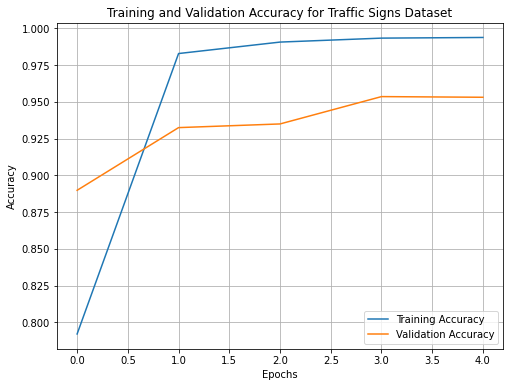

In [10]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(0, len(train_accuracy))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Traffic Signs Dataset')
plt.legend()
plt.grid()
plt.show()

In [9]:
results = model_RAN.evaluate(test_loader, return_dict=True)
print(f"Loss: {results['loss']}")
print(f"Accuracy: {results['accuracy']}")
print(f"Top-1 Accuracy: {results['top_k_accuracy']}")

198/198 [==============================] - 3s 13ms/step - loss: 0.2703 - accuracy: 0.9388 - top_k_accuracy: 0.9851
Loss: 0.270260214805603
Accuracy: 0.9387965202331543
Top-1 Accuracy: 0.9851148128509521


### Determine which classes the model has trouble predicting (<80% acc.)

In [41]:
class_acc(model_RAN, test_loader)

Accuracy of Speed limit (20km/h): 78.33%
Accuracy of Dangerous curve to the right: 73.33%
Accuracy of Double curve: 54.44%
Accuracy of Pedestrians: 48.33%
Accuracy of End of no passing: 71.67%


## Comparing Performance Against ResNet 18

In [11]:
def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    def residual_block(x, filters, downsample=False):
        shortcut = x
        if downsample:
            # Adjust the shortcut for downsampling and filter change
            shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        # First convolution
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolution
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Add the shortcut to the output
        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)
        return x

    # Add residual blocks for different filter sizes
    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters, downsample=True)  # Downsample for the first block
        x = residual_block(x, filters)  # Normal residual block

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

model_rn18 = resnet18((32, 32, 3), len(classes))

model_rn18.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)]
)


In [14]:
history = model_rn18.fit(
    train_loader,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=val_loader,
    epochs=5
)
test_loss, test_accuracy, top_k_acc = model_rn18.evaluate(test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}, Top K Accuracy: {top_k_acc:.4f}")

Epoch 1/5
1359/1359 [==============================] - 76s 46ms/step - loss: 2.1947 - accuracy: 0.3852 - sparse_top_k_categorical_accuracy: 0.3852 - val_loss: 0.7052 - val_accuracy: 0.8240 - val_sparse_top_k_categorical_accuracy: 0.8240
Epoch 2/5
1359/1359 [==============================] - 62s 45ms/step - loss: 0.1525 - accuracy: 0.9547 - sparse_top_k_categorical_accuracy: 0.9547 - val_loss: 0.3872 - val_accuracy: 0.9075 - val_sparse_top_k_categorical_accuracy: 0.9075
Epoch 3/5
1359/1359 [==============================] - 61s 45ms/step - loss: 0.0815 - accuracy: 0.9756 - sparse_top_k_categorical_accuracy: 0.9756 - val_loss: 0.5092 - val_accuracy: 0.8857 - val_sparse_top_k_categorical_accuracy: 0.8857
Epoch 4/5
1359/1359 [==============================] - 61s 45ms/step - loss: 0.0611 - accuracy: 0.9806 - sparse_top_k_categorical_accuracy: 0.9806 - val_loss: 0.2413 - val_accuracy: 0.9447 - val_sparse_top_k_categorical_accuracy: 0.9447
Epoch 5/5
198/198 [==============================] -

In [13]:
model_rn18.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 16, 64)   256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_21[0][0]     
______________________________________________________________________________________________